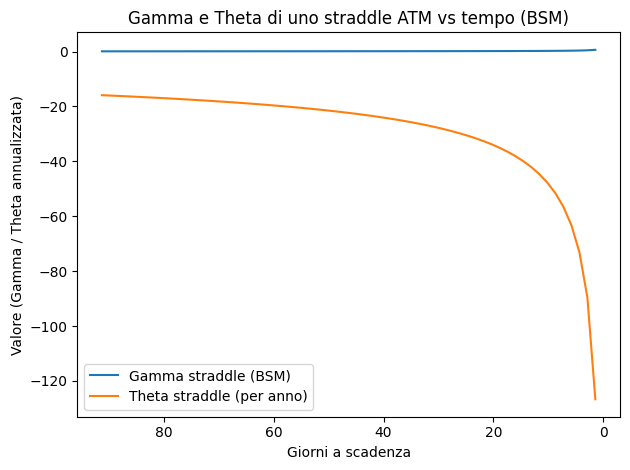

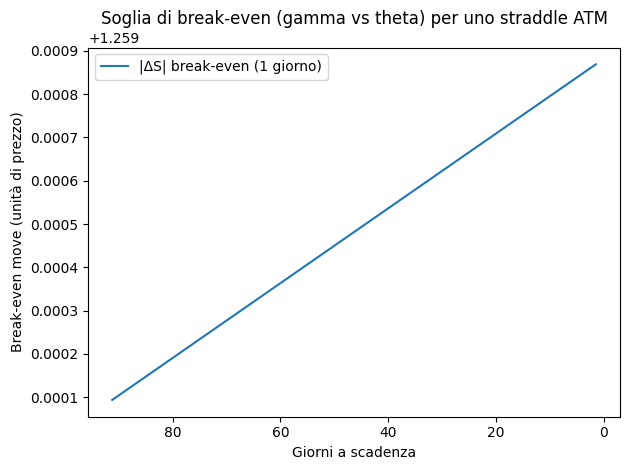

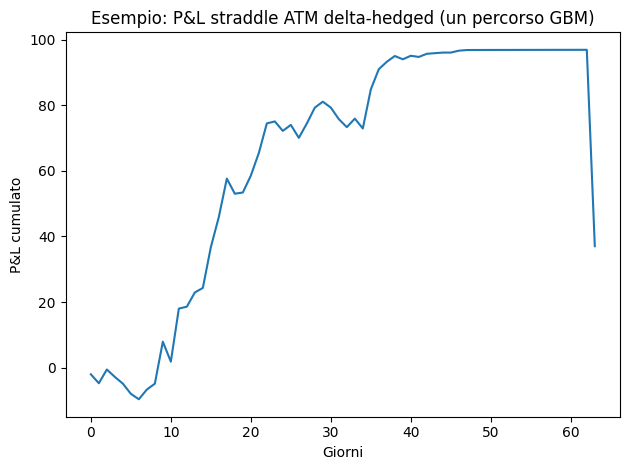

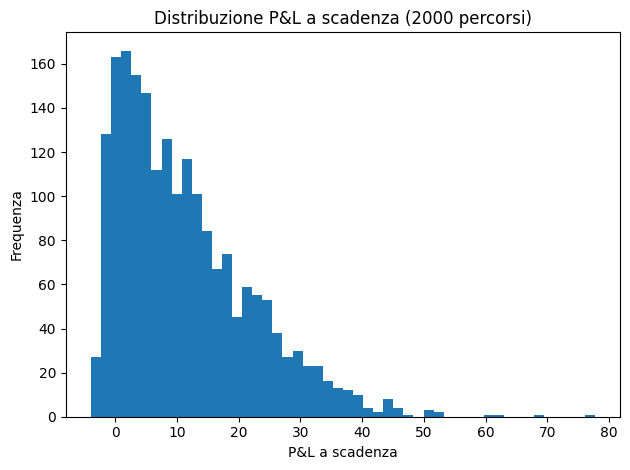

mean      11.300461
std       10.794385
min       -3.904983
q05       -1.259541
median     8.832278
q95       32.170515
max       77.668418
dtype: float64


In [1]:
# Gamma trading demo ispirato a Derman (P&L hedged in BSM) e Rebonato (gamma-theta).
# Cosa fa:
# 1) Greeks BSM (call/put) e per uno straddle ATM.
# 2) Limite di break-even dai termini gamma vs theta: |dS| = sqrt(-2 * Theta * dt / Gamma).
# 3) Simulazione GBM con copertura delta discreta; P&L del portafoglio (long straddle + hedge).
#
# Ipotesi: Black–Scholes, r e q costanti, nessun costo di transazione.
# Delta di copertura calcolato con volatilità implicita sigma_imp; il sottostante evolve con sigma_real.

import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt, exp
from scipy.stats import norm
import pandas as pd

# ------------------------------
# BSM helpers
# ------------------------------
def d1(S, K, tau, r, q, sigma):
    if tau <= 0 or sigma <= 0:
        return np.nan
    return (np.log(S/K) + (r - q + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))

def d2(S, K, tau, r, q, sigma):
    return d1(S, K, tau, r, q, sigma) - sigma*np.sqrt(tau)

def call_price(S, K, tau, r, q, sigma):
    if tau <= 0:
        return max(S-K, 0.0)
    D1 = d1(S,K,tau,r,q,sigma)
    D2 = D1 - sigma*np.sqrt(tau)
    return S*np.exp(-q*tau)*norm.cdf(D1) - K*np.exp(-r*tau)*norm.cdf(D2)

def put_price(S, K, tau, r, q, sigma):
    if tau <= 0:
        return max(K-S, 0.0)
    D1 = d1(S,K,tau,r,q,sigma)
    D2 = D1 - sigma*np.sqrt(tau)
    return K*np.exp(-r*tau)*norm.cdf(-D2) - S*np.exp(-q*tau)*norm.cdf(-D1)

def call_delta(S, K, tau, r, q, sigma):
    if tau <= 0:
        return 1.0 if S > K else 0.0
    return np.exp(-q*tau)*norm.cdf(d1(S,K,tau,r,q,sigma))

def put_delta(S, K, tau, r, q, sigma):
    return call_delta(S,K,tau,r,q,sigma) - np.exp(-q*tau)

def gamma_bsm(S, K, tau, r, q, sigma):
    if tau <= 0 or sigma <= 0:
        return 0.0
    D1 = d1(S,K,tau,r,q,sigma)
    return np.exp(-q*tau) * norm.pdf(D1) / (S*sigma*np.sqrt(tau))

def theta_call(S, K, tau, r, q, sigma):
    if tau <= 0 or sigma <= 0:
        return 0.0
    D1 = d1(S,K,tau,r,q,sigma)
    D2 = D1 - sigma*np.sqrt(tau)
    term1 = - (S*np.exp(-q*tau) * norm.pdf(D1) * sigma) / (2*np.sqrt(tau))
    term2 = - r*K*np.exp(-r*tau) * norm.cdf(D2)
    term3 = q*S*np.exp(-q*tau) * norm.cdf(D1)
    return term1 + term2 + term3

def theta_put(S, K, tau, r, q, sigma):
    if tau <= 0 or sigma <= 0:
        return 0.0
    D1 = d1(S,K,tau,r,q,sigma)
    D2 = D1 - sigma*np.sqrt(tau)
    term1 = - (S*np.exp(-q*tau) * norm.pdf(D1) * sigma) / (2*np.sqrt(tau))
    term2 = + r*K*np.exp(-r*tau) * norm.cdf(-D2)
    term3 = - q*S*np.exp(-q*tau) * norm.cdf(-D1)
    return term1 + term2 + term3

# Straddle helpers
def straddle_price(S, K, tau, r, q, sigma):
    return call_price(S,K,tau,r,q,sigma) + put_price(S,K,tau,r,q,sigma)

def straddle_delta(S, K, tau, r, q, sigma):
    return call_delta(S,K,tau,r,q,sigma) + put_delta(S,K,tau,r,q,sigma)

# ------------------------------
# Parametri
# ------------------------------
S0 = 100.0
K  = S0            # ATM
r  = 0.01
q  = 0.00
sigma_imp  = 0.20  # implied usata per pricing/hedging
sigma_real = 0.18  # realized del sottostante
T  = 0.25          # anni (~3 mesi)

# Tempo discreto
days_per_year = 252
N  = int(T*days_per_year)
dt = 1.0/days_per_year
taus = np.linspace(T, 1.0/days_per_year, N)  # evito tau=0

# ------------------------------
# A) Gamma e Theta dello straddle vs tempo
# ------------------------------
gammas = np.array([2*gamma_bsm(S0, K, tau, r, q, sigma_imp) for tau in taus])  # straddle: call+put = 2*gamma
thetas = np.array([theta_call(S0, K, tau, r, q, sigma_imp) +
                   theta_put (S0, K, tau, r, q, sigma_imp) for tau in taus])

plt.figure()
plt.plot(taus*365, gammas, label="Gamma straddle (BSM)")
plt.plot(taus*365, thetas, label="Theta straddle (per anno)")
plt.gca().invert_xaxis()
plt.xlabel("Giorni a scadenza")
plt.ylabel("Valore (Gamma / Theta annualizzata)")
plt.title("Gamma e Theta di uno straddle ATM vs tempo (BSM)")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------
# B) Soglia di break-even (gamma vs theta) giornaliera
# PnL ~ 0.5*Gamma*(dS)^2 + Theta*dt  -> |dS|_BE = sqrt(-2*Theta*dt / Gamma)
# ------------------------------
dt_day = 1.0/days_per_year
be_moves = np.zeros_like(taus)
for i, tau in enumerate(taus):
    G  = 2*gamma_bsm(S0, K, tau, r, q, sigma_imp)
    Th = theta_call(S0, K, tau, r, q, sigma_imp) + theta_put(S0, K, tau, r, q, sigma_imp)  # annuale
    Th_day = Th * dt_day
    be_moves[i] = np.sqrt(-2.0 * Th_day / G) if (G > 0 and Th_day < 0) else np.nan

plt.figure()
plt.plot(taus*365, be_moves, label="|ΔS| break-even (1 giorno)")
plt.gca().invert_xaxis()
plt.xlabel("Giorni a scadenza")
plt.ylabel("Break-even move (unità di prezzo)")
plt.title("Soglia di break-even (gamma vs theta) per uno straddle ATM")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------
# C) Simulazione GBM + P&L delta-hedged
# ------------------------------
rng = np.random.default_rng(42)
n_paths = 2000
S_paths = np.zeros((n_paths, N+1))
S_paths[:,0] = S0
for t in range(N):
    z = rng.standard_normal(n_paths)
    S_paths[:,t+1] = S_paths[:,t] * np.exp((r - q - 0.5*sigma_real**2)*dt + sigma_real*np.sqrt(dt)*z)

PL_terminal = np.zeros(n_paths)
for i in range(n_paths):
    cash = 0.0
    # acquisto straddle e hedge iniziale
    V0 = straddle_price(S_paths[i,0], K, T, r, q, sigma_imp)
    d0 = straddle_delta(S_paths[i,0], K, T, r, q, sigma_imp)
    cash -= V0
    cash -= -d0 * S_paths[i,0]  # finanzio la posizione in sottostante
    delta_prev = d0
    # rebalance giornaliero
    for t in range(N):
        cash *= np.exp(r*dt)  # conto cassa remunera a r
        tau = max(T - (t+1)*dt, 0.0)
        delta_new = straddle_delta(S_paths[i,t+1], K, tau, r, q, sigma_imp) if tau>0 else 0.0
        cash -= (delta_new - delta_prev) * S_paths[i,t+1]  # trade per aggiornare l’hedge
        delta_prev = delta_new
    # payoff finale
    V_T = straddle_price(S_paths[i,-1], K, 0.0, r, q, sigma_imp)
    cash += V_T
    PL_terminal[i] = cash

# Una serie di P&L cumulato per un singolo percorso (illustrazione)
i = 0
cash_ts = []
cash = 0.0
V0 = straddle_price(S_paths[i,0], K, T, r, q, sigma_imp)
d0 = straddle_delta(S_paths[i,0], K, T, r, q, sigma_imp)
cash -= V0
cash -= -d0 * S_paths[i,0]
delta_prev = d0
cash_ts.append(cash)
for t in range(N):
    cash *= np.exp(r*dt)
    tau = max(T - (t+1)*dt, 0.0)
    delta_new = straddle_delta(S_paths[i,t+1], K, tau, r, q, sigma_imp) if tau>0 else 0.0
    cash -= (delta_new - delta_prev) * S_paths[i,t+1]
    delta_prev = delta_new
    cash_ts.append(cash)
V_T = straddle_price(S_paths[i,-1], K, 0.0, r, q, sigma_imp)
cash_ts[-1] += V_T

plt.figure()
plt.plot(np.arange(N+1), cash_ts)
plt.xlabel("Giorni")
plt.ylabel("P&L cumulato")
plt.title("Esempio: P&L straddle ATM delta-hedged (un percorso GBM)")
plt.tight_layout()
plt.show()

# Istogramma P&L a scadenza
plt.figure()
plt.hist(PL_terminal, bins=50)
plt.xlabel("P&L a scadenza")
plt.ylabel("Frequenza")
plt.title(f"Distribuzione P&L a scadenza ({n_paths} percorsi)")
plt.tight_layout()
plt.show()

# Statistiche di riepilogo
summary = pd.Series({
    "mean": np.mean(PL_terminal),
    "std": np.std(PL_terminal, ddof=1),
    "min": np.min(PL_terminal),
    "q05": np.quantile(PL_terminal, 0.05),
    "median": np.median(PL_terminal),
    "q95": np.quantile(PL_terminal, 0.95),
    "max": np.max(PL_terminal)
})
print(summary)
